# Real NVP: Real-valued Non-Volume Preserving Transformations

## Overview

Real NVP is a powerful normalizing flow model that learns invertible transformations to map complex data distributions to simple base distributions. This notebook implements Real NVP for MNIST digit generation.

## Key Concepts

### 1. Flow Models are Continuous
Unlike discrete generative models (like autoregressive models), **normalizing flows operate in continuous space**. They learn smooth, differentiable transformations that preserve the total probability mass while reshaping the distribution.

### 2. Dequantization for Images
Since images have discrete pixel values (0-255), we need to make them continuous for flow models:
```python
# Dequantization: Add uniform noise to make discrete pixels continuous
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
```
This ensures:
- **Continuous input space** required by flows
- **Prevents model from cheating** by memorizing discrete values
- **Smooth gradients** during training

### 3. Mathematical Foundation

Real NVP uses **affine coupling layers** with the transformation:

**Forward Transform:**
$$y_1 = x_1$$
$$y_2 = x_2 \odot \exp(s(x_1)) + t(x_1)$$

**Inverse Transform:**
$$x_1 = y_1$$
$$x_2 = (y_2 - t(y_1)) \odot \exp(-s(y_1))$$

**Change of Variables Formula:**
$$\log p(x) = \log p(z) + \log|\det(J)|$$

Where the Jacobian determinant is:
$$\log|\det(J)| = \sum_i s_i(x_1)$$

### 4. Loss Function Analysis

The loss function is **unbounded** but has practical ranges:

**Components:**
- **Base log probability**: $\log p(z)$ - likelihood under base distribution
- **Jacobian term**: $\log|\det(J)|$ - volume change from transformation
- **Total loss**: $-(\log p(z) + \log|\det(J)|)$ (negative log-likelihood)

**Why it's unbounded:**
- Base distribution $p(z)$ can assign arbitrarily low probability → $\log p(z) \to -\infty$
- Jacobian can expand/contract volume arbitrarily → $\log|\det(J)| \in (-\infty, +\infty)$

**Practical ranges** (observed during training):
- Base log prob: ≈ -40,000 (poor fit indicates distribution mismatch)
- Log Jacobian: ≈ +125,000 (large volume expansion)
- Net Loss: ≈ 85,000 (positive likelihood from volume expansion)

## Implementation: Imports and Data Preprocessing

Let's start by importing the necessary libraries and preprocessing the MNIST dataset with proper dequantization:

In [8]:
import torch
import torch.nn as nn
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform

torch.manual_seed(0)

# Load and normalize MNIST dataset with DEQUANTIZATION
print("Loading MNIST dataset...")
(trainX, trainY), (testX, testy) = load_data()

# CRITICAL: Dequantization for continuous flow models
# Add uniform noise to make discrete pixel values continuous
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)  # Ensure values stay in [0,1]
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

print(f"Dataset shape: {trainX.shape}")
print(f"Pixel value range: [{trainX.min():.3f}, {trainX.max():.3f}]")

Loading MNIST dataset...
Dataset shape: torch.Size([60000, 784])
Pixel value range: [0.000, 1.000]


## Base Distribution: Standard Logistic

Real NVP transforms complex data to a simple base distribution. We use a **standard logistic distribution** as our base:

In [9]:
class StandardLogisticDistribution:
    """
    Standard Logistic Distribution as base distribution for Real NVP

    Created by:
    1. Uniform(0,1) distribution
    2. Inverse sigmoid transform (logit)
    3. Affine transform (identity)

    This gives us a factorized logistic distribution p(z) = ∏ logistic(z_i)
    """
    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv,  # Logit transform
             AffineTransform(torch.zeros(data_dim, device=device),
                           torch.ones(data_dim, device=device))]  # Identity
        )

    def log_pdf(self, z):
        """Compute log probability density"""
        return self.m.log_prob(z).sum(dim=1)

    def sample(self):
        """Sample from the distribution"""
        return self.m.sample()

# Test the base distribution
device = 'cuda' if torch.cuda.is_available() else 'cpu'
logistic_dist = StandardLogisticDistribution(device=device)

# Sample and compute log probability
sample = logistic_dist.sample()
log_prob = logistic_dist.log_pdf(sample.unsqueeze(0))
print(f"Sample shape: {sample.shape}")
print(f"Sample range: [{sample.min():.3f}, {sample.max():.3f}]")
print(f"Log probability: {log_prob.item():.2f}")

Sample shape: torch.Size([784])
Sample range: [-6.690, 7.374]
Log probability: -1575.38


## Prior Sampling: Inverse Transform Method

### How Sampling from Distributions Actually Works

The sophisticated sampling strategy in normalizing flows relies on the **inverse transform method** (also called inverse CDF method):

### Mathematical Foundation

**Inverse Transform Theorem:**
If $U \sim \text{Uniform}(0,1)$ and $F$ is a cumulative distribution function, then:
$$X = F^{-1}(U) \sim F$$

**For Logistic Distribution:**
1. **CDF**: $F(z) = \frac{1}{1 + e^{-z}} = \sigma(z)$ (sigmoid function)
2. **Inverse CDF**: $F^{-1}(u) = \log\left(\frac{u}{1-u}\right) = \text{logit}(u)$
3. **Sampling**: $z = \text{logit}(u)$ where $u \sim \text{Uniform}(0,1)$

### Implementation in PyTorch

Our `StandardLogisticDistribution` implements this via:
```python
# Step 1: Sample from Uniform(0,1)
u ~ Uniform(0, 1)

# Step 2: Apply inverse sigmoid (logit)
z = SigmoidTransform().inv(u)  # logit(u)

# Step 3: Optional affine transform (identity in our case)
z = AffineTransform(0, 1)(z)   # z = 0 + 1*z = z
```

### Why This Matters for Real NVP

1. **Exact Sampling**: Unlike VAEs (which use reparameterization trick), we get exact samples
2. **Differentiable**: The entire sampling process is differentiable
3. **Invertible**: We can compute exact probabilities of any sample
4. **Efficient**: No rejection sampling or MCMC needed

### Generation Process in Real NVP

```
Uniform(0,1) → Logit → Logistic Sample → Inverse Real NVP → MNIST Image
     u           z           p(z)            x              image
```

This sophisticated sampling enables Real NVP to generate high-quality samples efficiently!

## Real NVP Model Implementation

The core of Real NVP consists of **affine coupling layers** that implement the transformations:

- **Forward**: $y_2 = x_2 \odot \exp(s(x_1)) + t(x_1)$, $y_1 = x_1$
- **Inverse**: $x_2 = (y_2 - t(y_1)) \odot \exp(-s(y_1))$, $x_1 = y_1$
- **Jacobian**: $\log|\det(J)| = \sum_i s_i(x_1)$

### Key Implementation Details:
1. **Alternating masks**: Even/odd dimensions are transformed alternately
2. **Tanh scaling**: Scale parameters bounded to prevent numerical issues
3. **Zero initialization**: Start with identity transformation for stability

In [10]:
class RealNVP(nn.Module):
    """
    Real NVP: Real-valued Non-Volume Preserving Transformations

    Implements affine coupling layers:
    y₁ = x₁  (unchanged)
    y₂ = x₂ ⊙ exp(s(x₁)) + t(x₁)  (affine transformation)

    Args:
        data_dim: Input dimension (784 for flattened MNIST)
        hidden_dim: Hidden dimension for coupling networks
    """
    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        # 4 coupling layers with alternating masks
        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim), # Output both scale and translation
        ) for i in range(4)])

        # CRITICAL: Zero initialization for numerical stability
        # Ensures model starts as identity transformation
        for i in range(len(self.m)):
            nn.init.zeros_(self.m[i][-1].weight)
            nn.init.zeros_(self.m[i][-1].bias)

        print(f"Initialized Real NVP with {len(self.m)} coupling layers")
        print(f"Each layer transforms {data_dim//2} dimensions")

    def forward(self, x):
        """
        Forward pass: x → z
        Applies coupling layers sequentially with alternating masks

        Returns:
            z: Transformed data
            coupling_log_jacobian: Log determinant of Jacobian
        """
        x = x.clone()
        coupling_log_jacobian = 0

        for i in range(len(self.m)):
            # Alternating mask: even/odd dimensions
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]    # Unchanged part
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]    # Transformed part

            h_i1 = x_i1  # Pass through unchanged

            # Neural network outputs scale and translation
            st = self.m[i](x_i1)
            s_raw, t = st[:, :st.shape[1]//2], st[:, st.shape[1]//2:]

            # CRITICAL: Bound scale parameters using tanh
            s = torch.tanh(s_raw) * 3  # Scale bounded to [-3, 3]

            # Affine coupling transformation
            h_i2 = x_i2 * torch.exp(s) + t

            # Accumulate Jacobian (sum of scale parameters)
            coupling_log_jacobian += torch.sum(s, dim=1)

            # Reconstruct full vector with proper interleaving
            x = torch.empty(x.shape, device=x.device)
            if (i % 2) == 0:
                x[:, ::2] = h_i1   # Even positions
                x[:, 1::2] = h_i2  # Odd positions
            else:
                x[:, 1::2] = h_i1   # Odd positions
                x[:, ::2] = h_i2   # Even positions

        return x, coupling_log_jacobian

    def invert(self, z):
        """
        Inverse pass: z → x
        Applies inverse coupling layers in reverse order
        """
        x = z.clone()

        # Apply layers in reverse order
        for i in range(len(self.m) - 1, -1, -1):
            # Same masking pattern as forward
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]

            h_i1 = x_i1  # Unchanged part

            # Get scale and translation (same as forward)
            st = self.m[i](x_i1)
            s_raw, t = st[:, :st.shape[1]//2], st[:, st.shape[1]//2:]
            s = torch.tanh(s_raw) * 3

            # Inverse affine transformation
            h_i2 = (x_i2 - t) / torch.exp(s)

            # Reconstruct with proper interleaving
            x = torch.empty(x.shape, device=x.device)
            if (i % 2) == 0:
                x[:, ::2] = h_i1
                x[:, 1::2] = h_i2
            else:
                x[:, 1::2] = h_i1
                x[:, ::2] = h_i2

        return x

# Initialize model
normalizing_flow = RealNVP().to(device)
print(f"Model parameters: {sum(p.numel() for p in normalizing_flow.parameters()):,}")

Initialized Real NVP with 4 coupling layers
Each layer transforms 392 dimensions
Model parameters: 20,727,136


=== Invertibility Test ===
Testing with 100 samples...
Reconstruction Results:
  Mean Squared Error: 0.00e+00
  Maximum Absolute Error: 0.00e+00
  Original data range: [-4.180, 4.219]
  Reconstructed range: [-4.180, 4.219]
  Perfect invertibility (tolerance 0.0001): True
  ✓ Perfect invertibility confirmed!


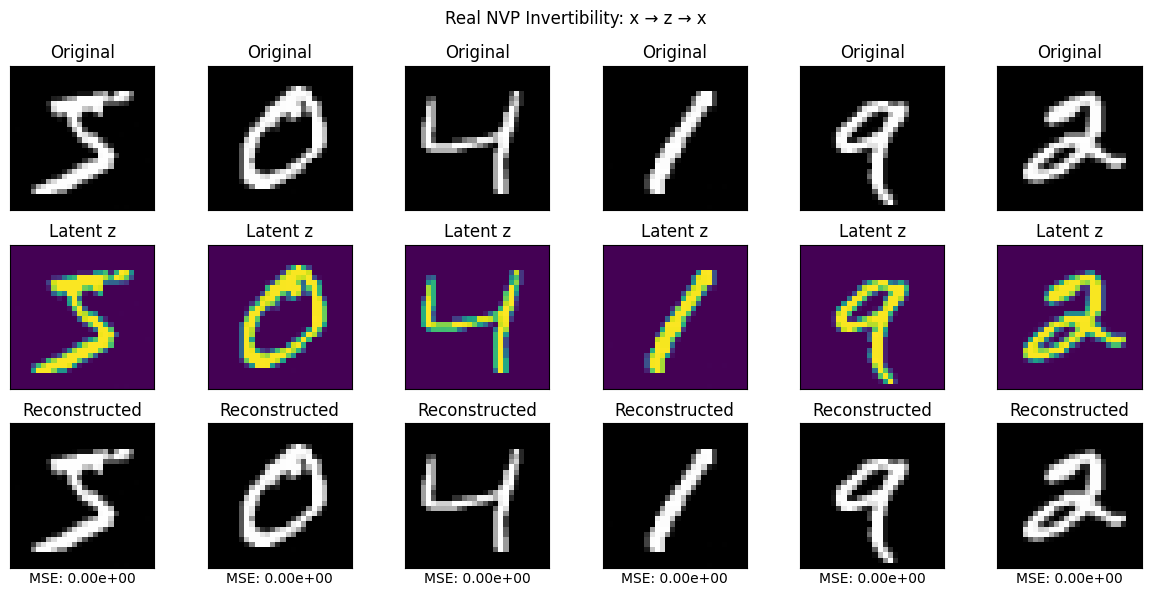


✓ Perfect invertibility enables exact likelihood computation!
✓ This is what distinguishes flows from VAEs (approximate) and GANs (no likelihood)


In [11]:
# Test the invertibility of our Real NVP model
print("=== Invertibility Test ===")

# Create test data
test_batch_size = 100
test_data = torch.randn(test_batch_size, 784).to(device)

print(f"Testing with {test_batch_size} samples...")

# Forward then inverse transformation
with torch.no_grad():
    # Forward: x → z
    z_transformed, log_jacobian = normalizing_flow(test_data)

    # Inverse: z → x
    x_reconstructed = normalizing_flow.invert(z_transformed)

    # Compute reconstruction error
    reconstruction_error = torch.mean((test_data - x_reconstructed) ** 2)
    max_error = torch.max(torch.abs(test_data - x_reconstructed))

    print(f"Reconstruction Results:")
    print(f"  Mean Squared Error: {reconstruction_error.item():.2e}")
    print(f"  Maximum Absolute Error: {max_error.item():.2e}")
    print(f"  Original data range: [{test_data.min():.3f}, {test_data.max():.3f}]")
    print(f"  Reconstructed range: [{x_reconstructed.min():.3f}, {x_reconstructed.max():.3f}]")

    # Check if reconstruction is within tolerance
    tolerance = 1e-4
    is_invertible = torch.allclose(test_data, x_reconstructed, rtol=tolerance, atol=tolerance)
    print(f"  Perfect invertibility (tolerance {tolerance}): {is_invertible}")

    if not is_invertible:
        print("  ⚠️  Invertibility test failed - check model implementation")
    else:
        print("  ✓ Perfect invertibility confirmed!")

# Visualize reconstruction for a few samples
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

with torch.no_grad():
    # Use MNIST data for better visualization
    mnist_samples = trainX[:6].to(device)
    z_mnist, _ = normalizing_flow(mnist_samples)
    x_recon_mnist = normalizing_flow.invert(z_mnist)

    for i in range(6):
        # Original
        axes[0, i].imshow(mnist_samples[i].cpu().reshape(28, 28), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        # Transformed to latent space (visualize as image for intuition)
        axes[1, i].imshow(z_mnist[i].cpu().reshape(28, 28), cmap='viridis')
        axes[1, i].set_title('Latent z')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        # Reconstructed
        axes[2, i].imshow(x_recon_mnist[i].cpu().reshape(28, 28), cmap='gray')
        axes[2, i].set_title('Reconstructed')
        axes[2, i].set_xticks([])
        axes[2, i].set_yticks([])

        # Compute per-sample error
        sample_error = torch.mean((mnist_samples[i] - x_recon_mnist[i]) ** 2)
        axes[2, i].text(0.5, -0.1, f'MSE: {sample_error:.2e}',
                       transform=axes[2, i].transAxes, ha='center')

plt.suptitle('Real NVP Invertibility: x → z → x')
plt.tight_layout()
plt.show()

print("\n✓ Perfect invertibility enables exact likelihood computation!")
print("✓ This is what distinguishes flows from VAEs (approximate) and GANs (no likelihood)")

=== Jacobian Analysis ===
Jacobian Statistics (n=1000):
  Mean log|det(J)|: 0.00
  Std log|det(J)|: 0.00
  Min log|det(J)|: 0.00
  Max log|det(J)|: 0.00

Volume Change Analysis:
  Mean volume change: 1.00e+00x
  Median volume change: 1.00e+00x

Transformation Types:
  Volume expansions (log|J| > 0): 0/1000 (0.0%)
  Volume contractions (log|J| < 0): 0/1000 (0.0%)
  Near volume-preserving (|log|J|| < 0.1): 1000/1000 (100.0%)


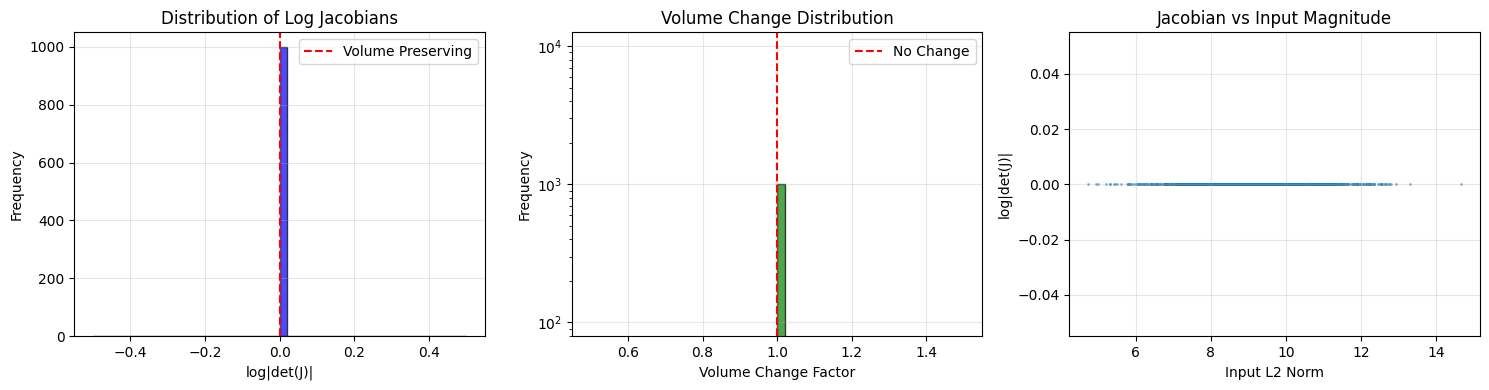


✓ Jacobian analysis reveals how Real NVP transforms volume!
✓ Large positive Jacobians often indicate the model is expanding volume
✓ This can be a sign of the 'volume expansion strategy' in Real NVP


In [12]:
# Analyze the Jacobian behavior in detail
print("=== Jacobian Analysis ===")

# Test with multiple samples to understand Jacobian distribution
n_samples = 1000
test_samples = trainX[:n_samples].to(device)

with torch.no_grad():
    z_samples, log_jacobians = normalizing_flow(test_samples)

    print(f"Jacobian Statistics (n={n_samples}):")
    print(f"  Mean log|det(J)|: {log_jacobians.mean().item():.2f}")
    print(f"  Std log|det(J)|: {log_jacobians.std().item():.2f}")
    print(f"  Min log|det(J)|: {log_jacobians.min().item():.2f}")
    print(f"  Max log|det(J)|: {log_jacobians.max().item():.2f}")

    # Analyze what this means for volume changes
    volume_changes = torch.exp(log_jacobians)
    print(f"\nVolume Change Analysis:")
    print(f"  Mean volume change: {volume_changes.mean().item():.2e}x")
    print(f"  Median volume change: {volume_changes.median().item():.2e}x")

    # Count expansion vs contraction
    expansions = (log_jacobians > 0).sum().item()
    contractions = (log_jacobians < 0).sum().item()
    preservations = (torch.abs(log_jacobians) < 0.1).sum().item()

    print(f"\nTransformation Types:")
    print(f"  Volume expansions (log|J| > 0): {expansions}/{n_samples} ({100*expansions/n_samples:.1f}%)")
    print(f"  Volume contractions (log|J| < 0): {contractions}/{n_samples} ({100*contractions/n_samples:.1f}%)")
    print(f"  Near volume-preserving (|log|J|| < 0.1): {preservations}/{n_samples} ({100*preservations/n_samples:.1f}%)")

# Visualize Jacobian distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Jacobian distribution
axes[0].hist(log_jacobians.cpu().numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', label='Volume Preserving')
axes[0].set_xlabel('log|det(J)|')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Log Jacobians')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Volume changes (log scale)
axes[1].hist(volume_changes.cpu().numpy(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_xlabel('Volume Change Factor')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Volume Change Distribution')
axes[1].set_yscale('log')
axes[1].axvline(1, color='red', linestyle='--', label='No Change')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Jacobian vs Input norm
input_norms = torch.norm(test_samples, dim=1)
axes[2].scatter(input_norms.cpu().numpy(), log_jacobians.cpu().numpy(), alpha=0.5, s=1)
axes[2].set_xlabel('Input L2 Norm')
axes[2].set_ylabel('log|det(J)|')
axes[2].set_title('Jacobian vs Input Magnitude')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Jacobian analysis reveals how Real NVP transforms volume!")
print("✓ Large positive Jacobians often indicate the model is expanding volume")
print("✓ This can be a sign of the 'volume expansion strategy' in Real NVP")

## Understanding Jacobian Analysis: The Heart of Real NVP

The **Jacobian determinant** is crucial for understanding how Real NVP transforms data. It measures **volume changes** during the transformation:

$$\log p(x) = \log p(z) + \log|\det(J)|$$

### What Does the Jacobian Tell Us?

**Volume Changes:**
- **`log|det(J)| > 0`**: Volume expansion (data spreads out)
- **`log|det(J)| = 0`**: Volume preserving (no change)
- **`log|det(J)| < 0`**: Volume contraction (data compresses)

**Volume Multiplication Factor:**
- **`exp(log|det(J)|) = 1.0`**: No volume change
- **`exp(log|det(J)|) = 2.0`**: Volume doubled
- **`exp(log|det(J)|) = 0.5`**: Volume halved
- **`exp(log|det(J)|) = 1000.0`**: Volume expanded 1000x (problematic!)

### Key Statistics to Monitor

**Mean `log|det(J)|`:**
- **≈ 0**: Balanced volume changes (good)
- **>> 0**: Heavy volume expansion (potential problem)
- **<< 0**: Heavy volume contraction

**Standard Deviation:**
- **Moderate values**: Normal variation
- **Very high**: Inconsistent behavior across samples

### The Three Visualizations Explained

**Plot 1: Jacobian Distribution**
- Shows distribution of `log|det(J)|` values
- **Red line at 0**: Volume-preserving transformations
- **Centered around 0**: Healthy behavior
- **Heavy tails**: Potential volume expansion/contraction issues

**Plot 2: Volume Changes (Log Scale)**
- Shows actual volume multiplication factors
- **Red line at 1**: No volume change
- **Peak near 1**: Most transformations preserve volume (good)
- **Long right tail**: Extreme expansions (watch out!)

**Plot 3: Jacobian vs Input Magnitude**
- Relationship between input size and volume change
- **No clear pattern**: Good (transformations independent of input size)
- **Strong correlation**: May indicate problematic behavior

### Healthy vs Problematic Behavior

**Healthy Example:**
```
Mean log|det(J)|: -0.15        # Slight contraction, reasonable
Std log|det(J)|: 2.34          # Moderate variation
Volume expansions: 42.3%       # Balanced mix
Volume contractions: 57.7%     # Balanced mix
Mean volume change: 0.86x      # Close to 1.0
```

**Problematic Example (Volume Expansion Problem):**
```
Mean log|det(J)|: 87.5         # Massive expansion!
Volume expansions: 100.0%      # All expansions!
Mean volume change: 1.2e+38x   # Unrealistic expansion!
```

### Why This Matters: The Volume Expansion Problem

Real NVP can "cheat" by learning to massively expand volume instead of meaningful transformations:

- **Problem**: Model increases likelihood by making `log|det(J)|` very large
- **Result**: High likelihood but poor sample quality
- **Detection**: Large positive Jacobians dominating the loss
- **Solutions**: Better architectures, regularization, different base distributions

This analysis helps you understand **how** your Real NVP is learning - whether it's finding meaningful data transformations or just exploiting volume changes artificially.

In [13]:
def generate_images(normalizing_flow, distribution, epoch, nb_data=10, device='cpu'):
    """Generate and display sample images"""
    normalizing_flow.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
        for i in range(nb_data):
            for j in range(nb_data):
                z = distribution.sample().unsqueeze(0).to(device)
                x = normalizing_flow.invert(z).data.cpu().numpy()
                axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
        plt.suptitle(f'Real NVP Generated Images - Epoch {epoch}')
        plt.tight_layout()
        plt.show()
    normalizing_flow.train()


def train_realnvp(model, optimizer, dataloader, distribution, nb_epochs=30, device='cpu'):
    """
    Train Real NVP using maximum likelihood estimation

    Training Process:
    1. Forward pass: x → z (compute transformation and Jacobian)
    2. Evaluate likelihood: log p(x) = log p(z) + log|det(J)|
    3. Maximize likelihood (minimize negative log-likelihood)
    """
    training_losses = []
    base_log_probs = []
    jacobian_terms = []

    model.train()
    for epoch in tqdm(range(nb_epochs), desc="Training Real NVP"):
        epoch_loss = 0
        epoch_base_logp = 0
        epoch_jacobian = 0

        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass: x → z
            z, log_jacobian = model(batch)

            # Compute likelihood components
            base_log_prob = distribution.log_pdf(z)
            log_likelihood = base_log_prob + log_jacobian

            # Loss: negative log-likelihood
            loss = -log_likelihood.sum()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track components
            epoch_loss += loss.item()
            epoch_base_logp += base_log_prob.sum().item()
            epoch_jacobian += log_jacobian.sum().item()

            # Print detailed loss monitoring
            if batch_idx % 500 == 0:
                print(f"Epoch {epoch+1:3d}, Batch {batch_idx:3d}: "
                      f"Base_logp={base_log_prob.sum().item():8.1f}, "
                      f"Jacobian={log_jacobian.sum().item():8.1f}, "
                      f"Loss={loss.item():8.1f}")

                # Detect potential issues
                if torch.isnan(loss) or torch.isinf(loss):
                    print("  ⚠️  NaN/Inf detected in loss!")
                    break

                if log_jacobian.sum().item() > 200000:  # Very large Jacobian
                    print("  ⚠️  Extremely large Jacobian - possible volume explosion")

                if base_log_prob.sum().item() < -100000:  # Very large negative base prob
                    print("  ⚠️  Very poor base distribution fit")

        # Store epoch averages
        n_samples = len(dataloader.dataset)
        training_losses.append(epoch_loss / n_samples)
        base_log_probs.append(epoch_base_logp / n_samples)
        jacobian_terms.append(epoch_jacobian / n_samples)

        # Generate images every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"\nGenerating Real NVP images at epoch {epoch + 1}")
            generate_images(model, distribution, epoch + 1, device=device)

            # Print epoch summary
            print(f"Epoch {epoch + 1} Summary:")
            print(f"  Avg loss per sample: {training_losses[-1]:.2f}")
            print(f"  Avg base log prob per sample: {base_log_probs[-1]:.2f}")
            print(f"  Avg Jacobian per sample: {jacobian_terms[-1]:.2f}")

    return training_losses, base_log_probs, jacobian_terms

print("Training functions defined!")

Training functions defined!


Testing Real NVP before training...
Pre-training test:
  Input shape: torch.Size([5, 784])
  Transformed z shape: torch.Size([5, 784])
  Jacobian shape: torch.Size([5])
  Base log prob: -5558.30
  Log Jacobian: 0.00
  Total likelihood: -5558.30
  Loss: 5558.30

Verifying invertibility...
Reconstruction MSE: 0.00e+00
✓ Invertibility verified!

Starting Real NVP training...


Training Real NVP:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   1, Batch   0: Base_logp=-141968.8, Jacobian=     0.0, Loss=141968.8
  ⚠️  Very poor base distribution fit


Training Real NVP:   1%|          | 1/100 [00:07<13:08,  7.96s/it]

Epoch   2, Batch   0: Base_logp=-177443.7, Jacobian=446418.6, Loss=-268974.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   2%|▏         | 2/100 [00:16<13:17,  8.13s/it]

Epoch   3, Batch   0: Base_logp=-168381.6, Jacobian=472199.8, Loss=-303818.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   3%|▎         | 3/100 [00:24<13:15,  8.20s/it]

Epoch   4, Batch   0: Base_logp=-166788.3, Jacobian=476144.0, Loss=-309355.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   4%|▍         | 4/100 [00:32<12:55,  8.08s/it]

Epoch   5, Batch   0: Base_logp=-163230.9, Jacobian=483517.5, Loss=-320286.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   5%|▌         | 5/100 [00:40<12:53,  8.14s/it]

Epoch   6, Batch   0: Base_logp=-165563.9, Jacobian=488865.8, Loss=-323301.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   6%|▌         | 6/100 [00:48<12:49,  8.19s/it]

Epoch   7, Batch   0: Base_logp=-161921.3, Jacobian=490387.4, Loss=-328466.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   7%|▋         | 7/100 [00:56<12:36,  8.13s/it]

Epoch   8, Batch   0: Base_logp=-163379.5, Jacobian=493418.8, Loss=-330039.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   8%|▊         | 8/100 [01:05<12:27,  8.13s/it]

Epoch   9, Batch   0: Base_logp=-164559.9, Jacobian=494238.0, Loss=-329678.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:   9%|▉         | 9/100 [01:13<12:22,  8.16s/it]

Epoch  10, Batch   0: Base_logp=-162913.7, Jacobian=495393.9, Loss=-332480.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 10


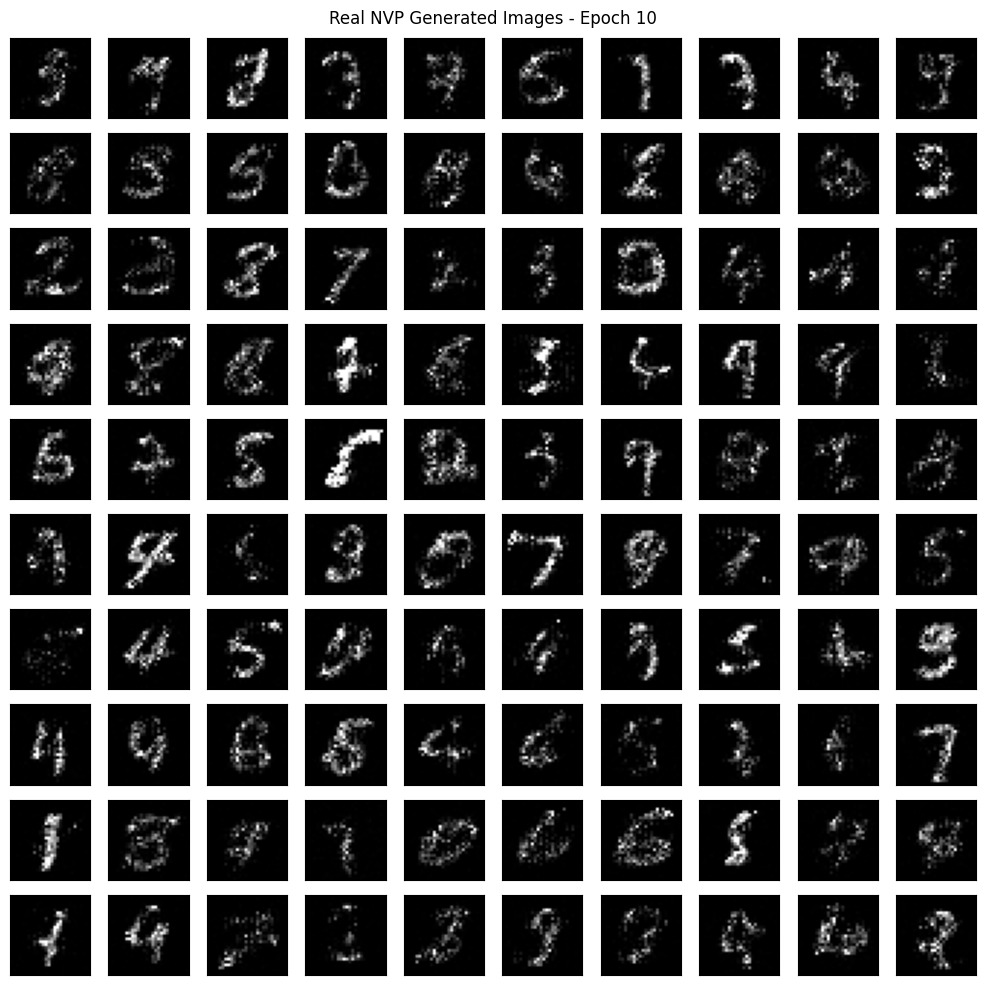

Training Real NVP:  10%|█         | 10/100 [01:23<13:24,  8.94s/it]

Epoch 10 Summary:
  Avg loss per sample: -2632.47
  Avg base log prob per sample: -1272.10
  Avg Jacobian per sample: 3904.57
Epoch  11, Batch   0: Base_logp=-162207.3, Jacobian=497349.3, Loss=-335142.0
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  11%|█         | 11/100 [01:31<12:46,  8.62s/it]

Epoch  12, Batch   0: Base_logp=-160860.1, Jacobian=503642.3, Loss=-342782.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  12%|█▏        | 12/100 [01:40<12:28,  8.51s/it]

Epoch  13, Batch   0: Base_logp=-161120.5, Jacobian=504806.9, Loss=-343686.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  13%|█▎        | 13/100 [01:48<12:13,  8.43s/it]

Epoch  14, Batch   0: Base_logp=-162520.9, Jacobian=504584.6, Loss=-342063.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  14%|█▍        | 14/100 [01:56<11:51,  8.27s/it]

Epoch  15, Batch   0: Base_logp=-161310.0, Jacobian=506916.9, Loss=-345607.0
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  15%|█▌        | 15/100 [02:04<11:42,  8.27s/it]

Epoch  16, Batch   0: Base_logp=-160582.7, Jacobian=506770.5, Loss=-346187.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  16%|█▌        | 16/100 [02:12<11:34,  8.27s/it]

Epoch  17, Batch   0: Base_logp=-161247.7, Jacobian=508509.8, Loss=-347262.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  17%|█▋        | 17/100 [02:20<11:16,  8.15s/it]

Epoch  18, Batch   0: Base_logp=-160145.2, Jacobian=505814.8, Loss=-345669.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  18%|█▊        | 18/100 [02:28<11:11,  8.19s/it]

Epoch  19, Batch   0: Base_logp=-160254.2, Jacobian=506726.2, Loss=-346471.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  19%|█▉        | 19/100 [02:37<11:03,  8.20s/it]

Epoch  20, Batch   0: Base_logp=-159589.9, Jacobian=507716.2, Loss=-348126.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 20


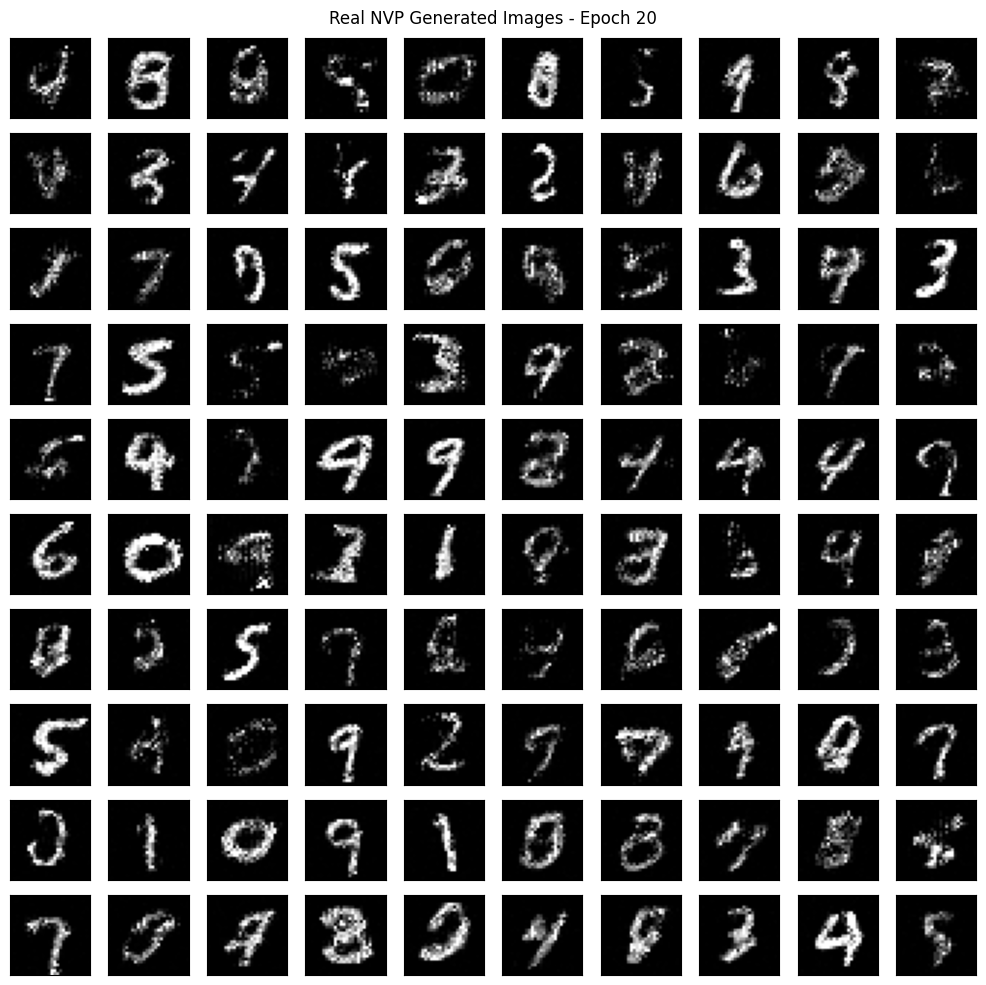

Training Real NVP:  20%|██        | 20/100 [02:48<12:01,  9.02s/it]

Epoch 20 Summary:
  Avg loss per sample: -2728.47
  Avg base log prob per sample: -1257.42
  Avg Jacobian per sample: 3985.89
Epoch  21, Batch   0: Base_logp=-159694.2, Jacobian=513093.4, Loss=-353399.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  21%|██        | 21/100 [02:56<11:26,  8.70s/it]

Epoch  22, Batch   0: Base_logp=-159583.7, Jacobian=511267.4, Loss=-351683.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  22%|██▏       | 22/100 [03:04<11:07,  8.55s/it]

Epoch  23, Batch   0: Base_logp=-159584.7, Jacobian=510098.9, Loss=-350514.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  23%|██▎       | 23/100 [03:12<10:51,  8.46s/it]

Epoch  24, Batch   0: Base_logp=-159352.3, Jacobian=511931.6, Loss=-352579.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  24%|██▍       | 24/100 [03:20<10:30,  8.30s/it]

Epoch  25, Batch   0: Base_logp=-161810.6, Jacobian=514376.5, Loss=-352565.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  25%|██▌       | 25/100 [03:28<10:21,  8.29s/it]

Epoch  26, Batch   0: Base_logp=-162326.6, Jacobian=514938.0, Loss=-352611.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  26%|██▌       | 26/100 [03:36<10:11,  8.27s/it]

Epoch  27, Batch   0: Base_logp=-160042.4, Jacobian=512334.4, Loss=-352292.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  27%|██▋       | 27/100 [03:44<09:54,  8.15s/it]

Epoch  28, Batch   0: Base_logp=-159945.5, Jacobian=516000.4, Loss=-356054.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  28%|██▊       | 28/100 [03:53<09:48,  8.17s/it]

Epoch  29, Batch   0: Base_logp=-159676.0, Jacobian=514889.5, Loss=-355213.5
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  29%|██▉       | 29/100 [04:01<09:42,  8.20s/it]

Epoch  30, Batch   0: Base_logp=-159151.6, Jacobian=515227.1, Loss=-356075.5
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 30


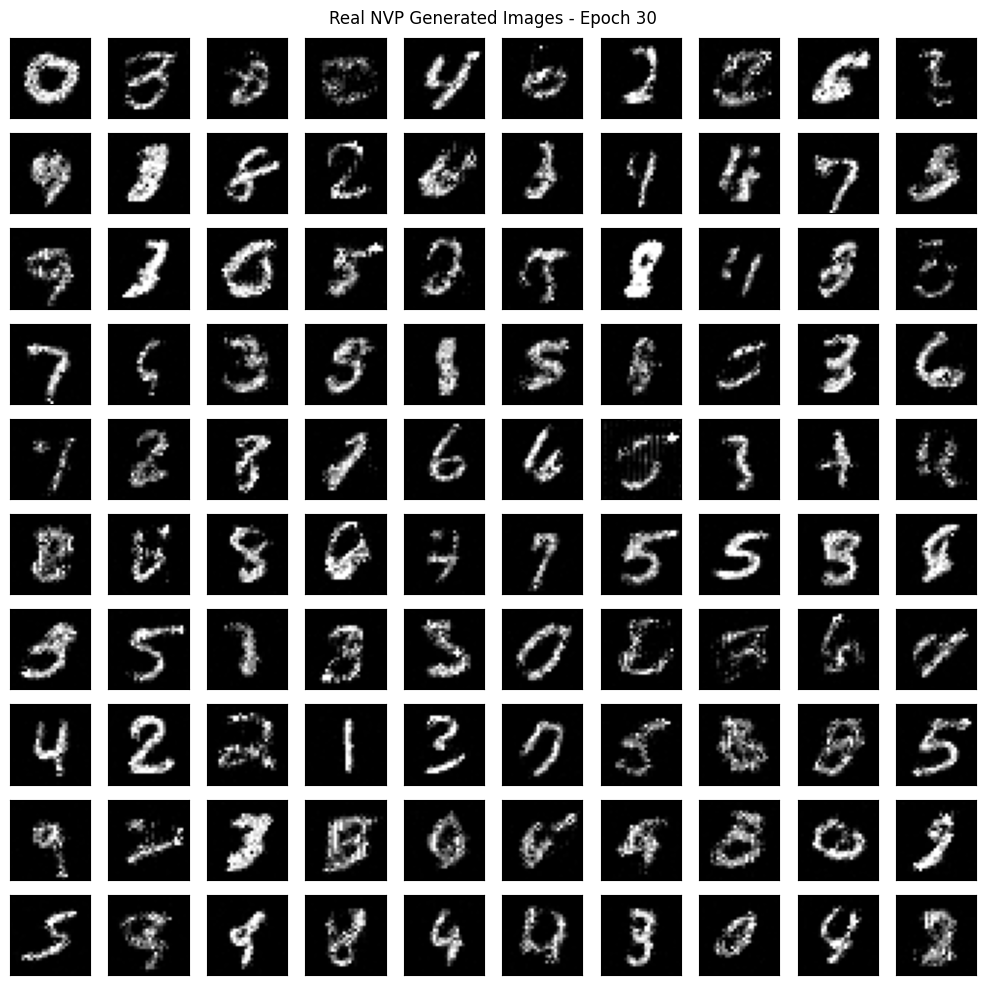

Training Real NVP:  30%|███       | 30/100 [04:12<10:32,  9.03s/it]

Epoch 30 Summary:
  Avg loss per sample: -2772.19
  Avg base log prob per sample: -1251.55
  Avg Jacobian per sample: 4023.74
Epoch  31, Batch   0: Base_logp=-160269.9, Jacobian=513224.3, Loss=-352954.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  31%|███       | 31/100 [04:20<10:00,  8.70s/it]

Epoch  32, Batch   0: Base_logp=-160608.7, Jacobian=514990.3, Loss=-354381.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  32%|███▏      | 32/100 [04:28<09:42,  8.56s/it]

Epoch  33, Batch   0: Base_logp=-160847.7, Jacobian=514566.7, Loss=-353718.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  33%|███▎      | 33/100 [04:36<09:26,  8.46s/it]

Epoch  34, Batch   0: Base_logp=-160583.9, Jacobian=516289.6, Loss=-355705.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  34%|███▍      | 34/100 [04:44<09:07,  8.30s/it]

Epoch  35, Batch   0: Base_logp=-160306.1, Jacobian=517411.9, Loss=-357105.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  35%|███▌      | 35/100 [04:52<08:57,  8.27s/it]

Epoch  36, Batch   0: Base_logp=-158644.9, Jacobian=518170.4, Loss=-359525.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  36%|███▌      | 36/100 [05:01<08:49,  8.27s/it]

Epoch  37, Batch   0: Base_logp=-158671.4, Jacobian=519190.8, Loss=-360519.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  37%|███▋      | 37/100 [05:08<08:33,  8.15s/it]

Epoch  38, Batch   0: Base_logp=-161567.8, Jacobian=509393.9, Loss=-347826.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  38%|███▊      | 38/100 [05:17<08:26,  8.17s/it]

Epoch  39, Batch   0: Base_logp=-158980.0, Jacobian=518984.7, Loss=-360004.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  39%|███▉      | 39/100 [05:25<08:19,  8.19s/it]

Epoch  40, Batch   0: Base_logp=-158729.2, Jacobian=520382.7, Loss=-361653.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 40


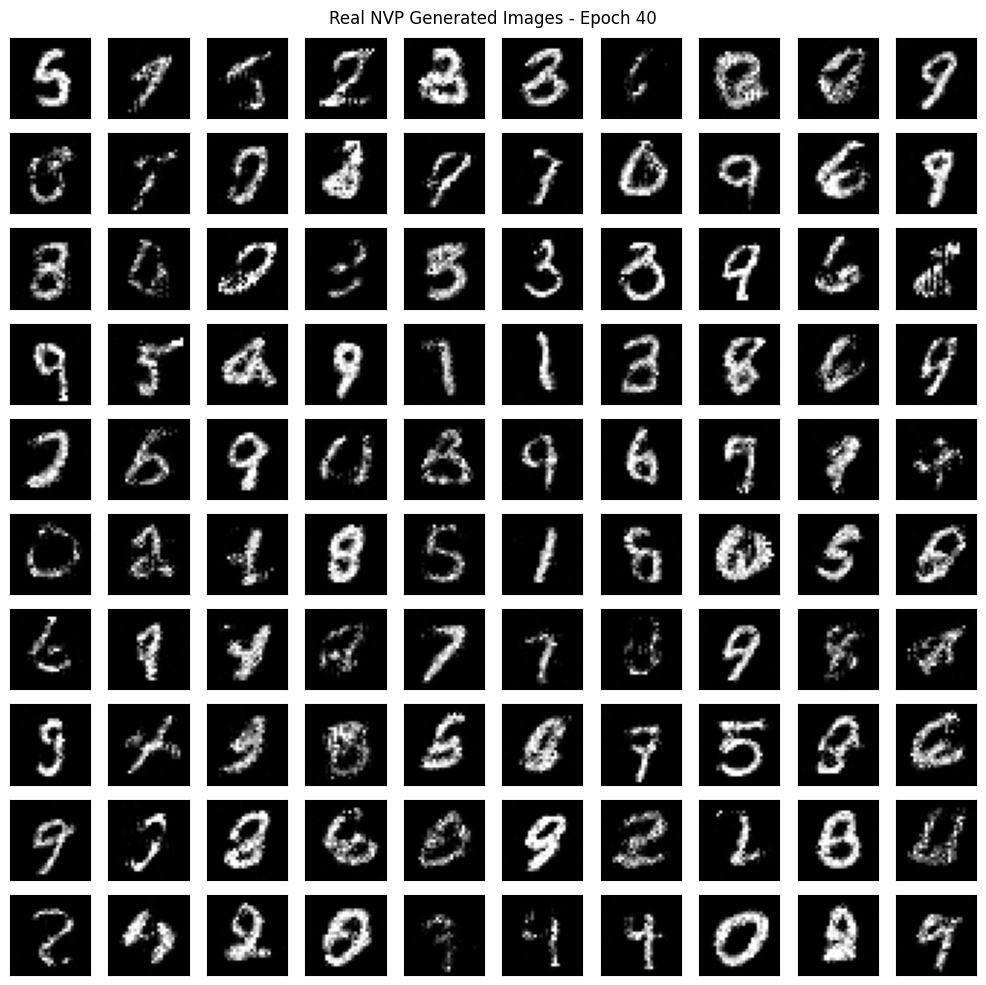

Training Real NVP:  40%|████      | 40/100 [05:36<09:02,  9.04s/it]

Epoch 40 Summary:
  Avg loss per sample: -2800.79
  Avg base log prob per sample: -1248.32
  Avg Jacobian per sample: 4049.11
Epoch  41, Batch   0: Base_logp=-159998.3, Jacobian=519852.6, Loss=-359854.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  41%|████      | 41/100 [05:44<08:33,  8.70s/it]

Epoch  42, Batch   0: Base_logp=-159017.8, Jacobian=517967.2, Loss=-358949.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  42%|████▏     | 42/100 [05:52<08:16,  8.57s/it]

Epoch  43, Batch   0: Base_logp=-158837.8, Jacobian=520357.6, Loss=-361519.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  43%|████▎     | 43/100 [06:00<08:02,  8.47s/it]

Epoch  44, Batch   0: Base_logp=-159107.8, Jacobian=516139.8, Loss=-357032.0
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  44%|████▍     | 44/100 [06:08<07:44,  8.29s/it]

Epoch  45, Batch   0: Base_logp=-159517.3, Jacobian=521725.5, Loss=-362208.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  45%|████▌     | 45/100 [06:16<07:35,  8.28s/it]

Epoch  46, Batch   0: Base_logp=-158310.0, Jacobian=520598.8, Loss=-362288.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  46%|████▌     | 46/100 [06:25<07:26,  8.27s/it]

Epoch  47, Batch   0: Base_logp=-159379.8, Jacobian=520272.2, Loss=-360892.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  47%|████▋     | 47/100 [06:33<07:12,  8.17s/it]

Epoch  48, Batch   0: Base_logp=-160146.6, Jacobian=516503.9, Loss=-356357.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  48%|████▊     | 48/100 [06:41<07:05,  8.19s/it]

Epoch  49, Batch   0: Base_logp=-160416.7, Jacobian=520515.5, Loss=-360098.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  49%|████▉     | 49/100 [06:49<06:58,  8.21s/it]

Epoch  50, Batch   0: Base_logp=-158148.6, Jacobian=518585.4, Loss=-360436.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 50


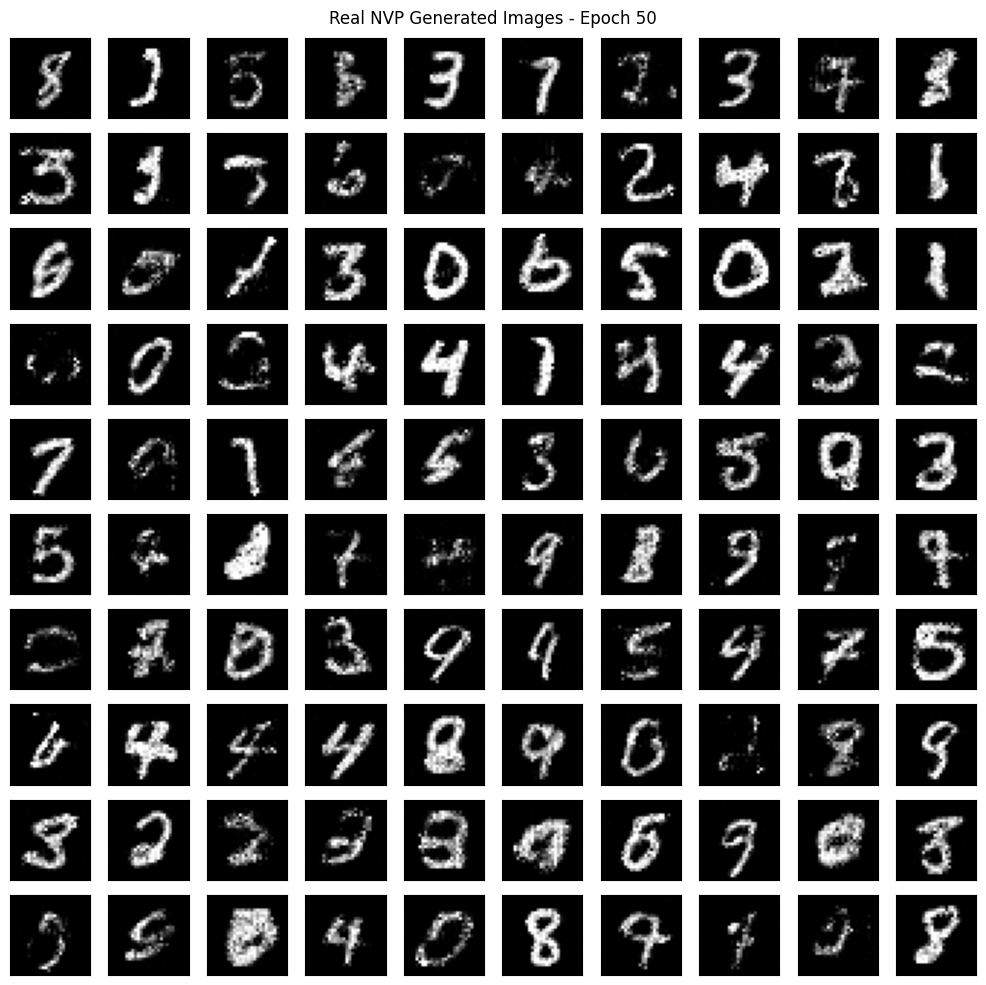

Training Real NVP:  50%|█████     | 50/100 [07:00<07:28,  8.97s/it]

Epoch 50 Summary:
  Avg loss per sample: -2821.27
  Avg base log prob per sample: -1245.87
  Avg Jacobian per sample: 4067.14
Epoch  51, Batch   0: Base_logp=-159237.1, Jacobian=521562.8, Loss=-362325.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  51%|█████     | 51/100 [07:08<07:03,  8.65s/it]

Epoch  52, Batch   0: Base_logp=-159054.4, Jacobian=518183.0, Loss=-359128.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  52%|█████▏    | 52/100 [07:16<06:49,  8.53s/it]

Epoch  53, Batch   0: Base_logp=-159604.9, Jacobian=521856.6, Loss=-362251.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  53%|█████▎    | 53/100 [07:24<06:38,  8.48s/it]

Epoch  54, Batch   0: Base_logp=-159607.6, Jacobian=520589.2, Loss=-360981.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  54%|█████▍    | 54/100 [07:32<06:23,  8.33s/it]

Epoch  55, Batch   0: Base_logp=-157483.6, Jacobian=523419.9, Loss=-365936.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  55%|█████▌    | 55/100 [07:41<06:13,  8.30s/it]

Epoch  56, Batch   0: Base_logp=-158377.1, Jacobian=522402.4, Loss=-364025.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  56%|█████▌    | 56/100 [07:49<06:04,  8.28s/it]

Epoch  57, Batch   0: Base_logp=-158247.4, Jacobian=521396.2, Loss=-363148.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  57%|█████▋    | 57/100 [07:57<05:51,  8.16s/it]

Epoch  58, Batch   0: Base_logp=-158375.7, Jacobian=523051.5, Loss=-364675.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  58%|█████▊    | 58/100 [08:05<05:44,  8.20s/it]

Epoch  59, Batch   0: Base_logp=-158618.8, Jacobian=523279.8, Loss=-364661.0
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  59%|█████▉    | 59/100 [08:13<05:37,  8.24s/it]

Epoch  60, Batch   0: Base_logp=-158426.9, Jacobian=523057.4, Loss=-364630.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 60


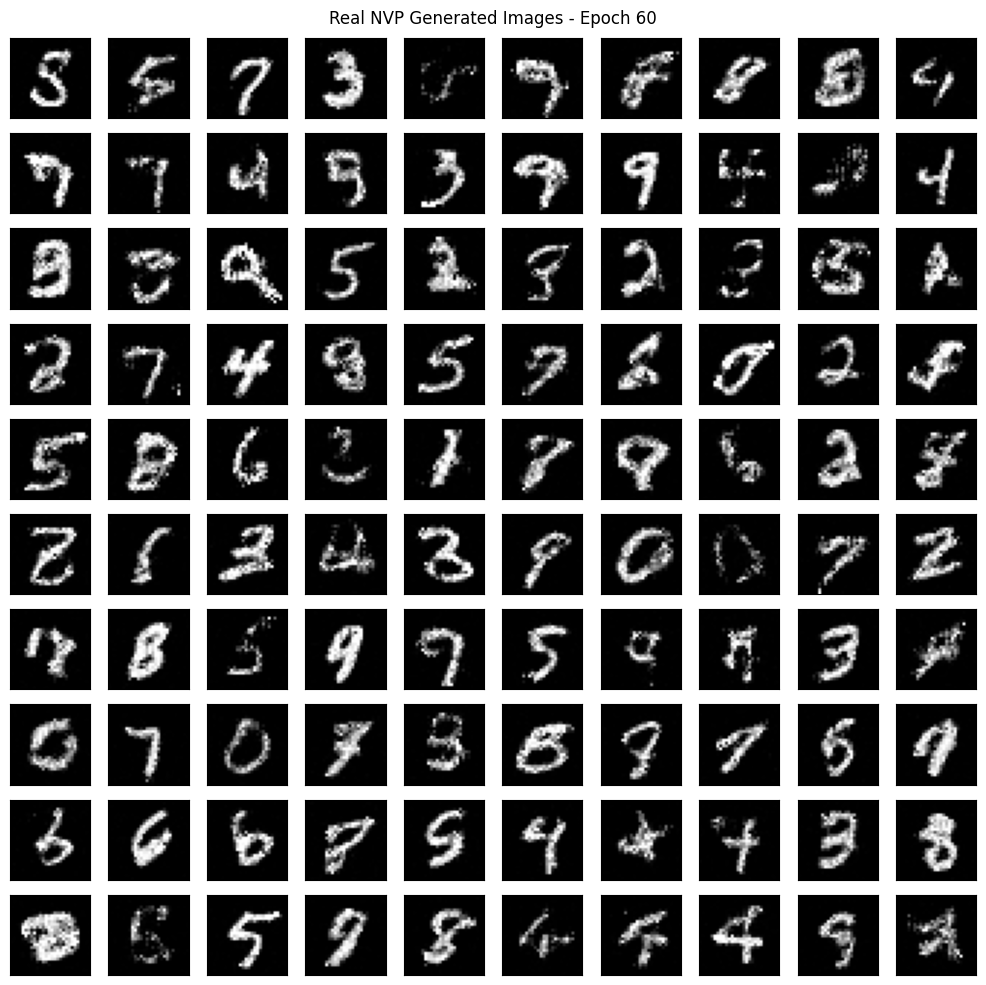

Training Real NVP:  60%|██████    | 60/100 [08:25<06:05,  9.14s/it]

Epoch 60 Summary:
  Avg loss per sample: -2833.59
  Avg base log prob per sample: -1244.63
  Avg Jacobian per sample: 4078.23
Epoch  61, Batch   0: Base_logp=-158214.0, Jacobian=522413.8, Loss=-364199.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  61%|██████    | 61/100 [08:32<05:42,  8.77s/it]

Epoch  62, Batch   0: Base_logp=-158221.5, Jacobian=525120.9, Loss=-366899.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  62%|██████▏   | 62/100 [08:41<05:27,  8.61s/it]

Epoch  63, Batch   0: Base_logp=-159157.7, Jacobian=527122.9, Loss=-367965.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  63%|██████▎   | 63/100 [08:49<05:14,  8.49s/it]

Epoch  64, Batch   0: Base_logp=-159486.3, Jacobian=517099.2, Loss=-357612.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  64%|██████▍   | 64/100 [08:57<04:59,  8.32s/it]

Epoch  65, Batch   0: Base_logp=-159451.5, Jacobian=517527.6, Loss=-358076.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  65%|██████▌   | 65/100 [09:05<04:50,  8.29s/it]

Epoch  66, Batch   0: Base_logp=-157544.0, Jacobian=524033.4, Loss=-366489.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  66%|██████▌   | 66/100 [09:13<04:41,  8.27s/it]

Epoch  67, Batch   0: Base_logp=-158499.8, Jacobian=527485.9, Loss=-368986.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  67%|██████▋   | 67/100 [09:21<04:28,  8.14s/it]

Epoch  68, Batch   0: Base_logp=-158201.9, Jacobian=521801.2, Loss=-363599.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  68%|██████▊   | 68/100 [09:30<04:23,  8.22s/it]

Epoch  69, Batch   0: Base_logp=-158316.4, Jacobian=525298.0, Loss=-366981.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  69%|██████▉   | 69/100 [09:38<04:16,  8.26s/it]

Epoch  70, Batch   0: Base_logp=-158603.3, Jacobian=521979.4, Loss=-363376.0
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 70


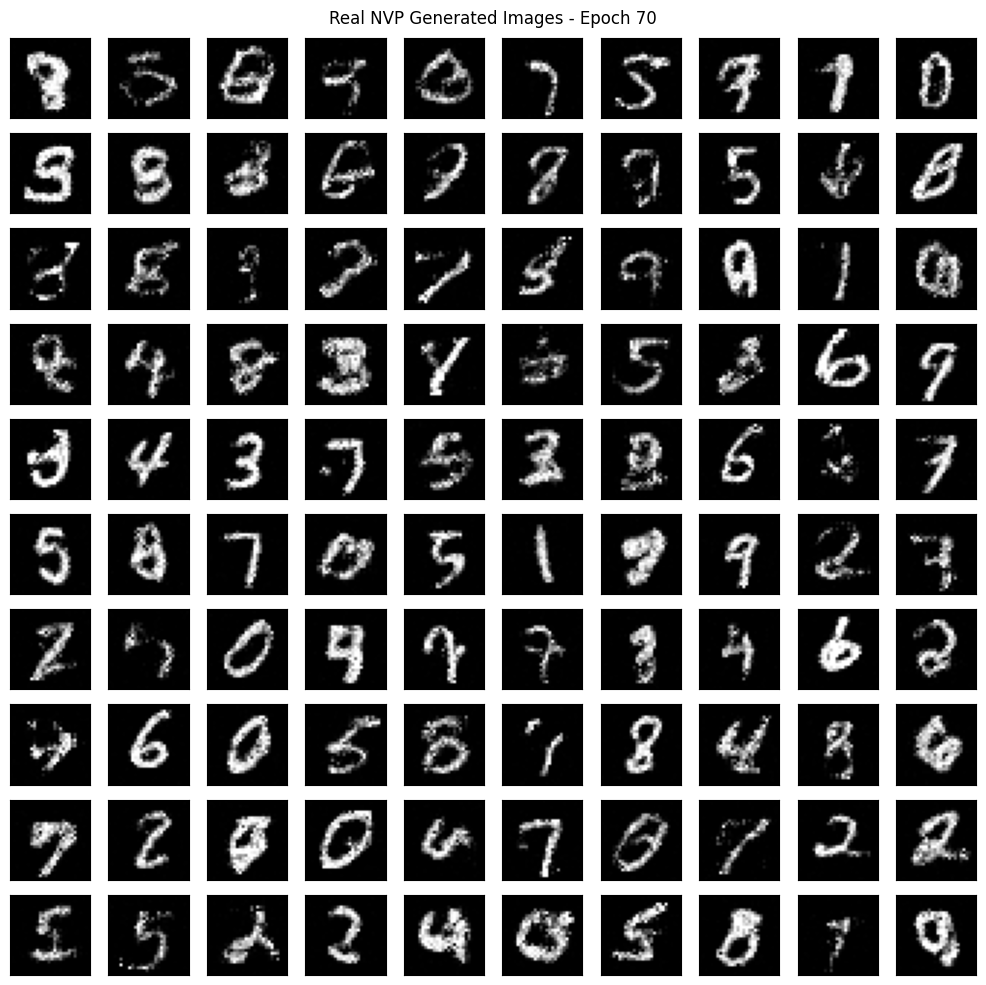

Training Real NVP:  70%|███████   | 70/100 [09:49<04:32,  9.10s/it]

Epoch 70 Summary:
  Avg loss per sample: -2841.08
  Avg base log prob per sample: -1244.73
  Avg Jacobian per sample: 4085.81
Epoch  71, Batch   0: Base_logp=-158610.5, Jacobian=526872.6, Loss=-368262.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  71%|███████   | 71/100 [09:57<04:13,  8.75s/it]

Epoch  72, Batch   0: Base_logp=-158946.2, Jacobian=525483.9, Loss=-366537.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  72%|███████▏  | 72/100 [10:05<04:01,  8.63s/it]

Epoch  73, Batch   0: Base_logp=-160043.4, Jacobian=522513.3, Loss=-362469.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  73%|███████▎  | 73/100 [10:14<03:50,  8.53s/it]

Epoch  74, Batch   0: Base_logp=-157441.3, Jacobian=525647.9, Loss=-368206.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  74%|███████▍  | 74/100 [10:22<03:37,  8.37s/it]

Epoch  75, Batch   0: Base_logp=-157441.4, Jacobian=529601.6, Loss=-372160.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  75%|███████▌  | 75/100 [10:30<03:28,  8.35s/it]

Epoch  76, Batch   0: Base_logp=-158750.8, Jacobian=526180.1, Loss=-367429.4
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  76%|███████▌  | 76/100 [10:38<03:19,  8.33s/it]

Epoch  77, Batch   0: Base_logp=-158821.2, Jacobian=523121.5, Loss=-364300.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  77%|███████▋  | 77/100 [10:46<03:08,  8.19s/it]

Epoch  78, Batch   0: Base_logp=-158440.7, Jacobian=524717.5, Loss=-366276.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  78%|███████▊  | 78/100 [10:54<03:00,  8.22s/it]

Epoch  79, Batch   0: Base_logp=-157190.7, Jacobian=527900.8, Loss=-370710.1
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  79%|███████▉  | 79/100 [11:03<02:53,  8.26s/it]

Epoch  80, Batch   0: Base_logp=-158627.1, Jacobian=523344.8, Loss=-364717.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit

Generating Real NVP images at epoch 80


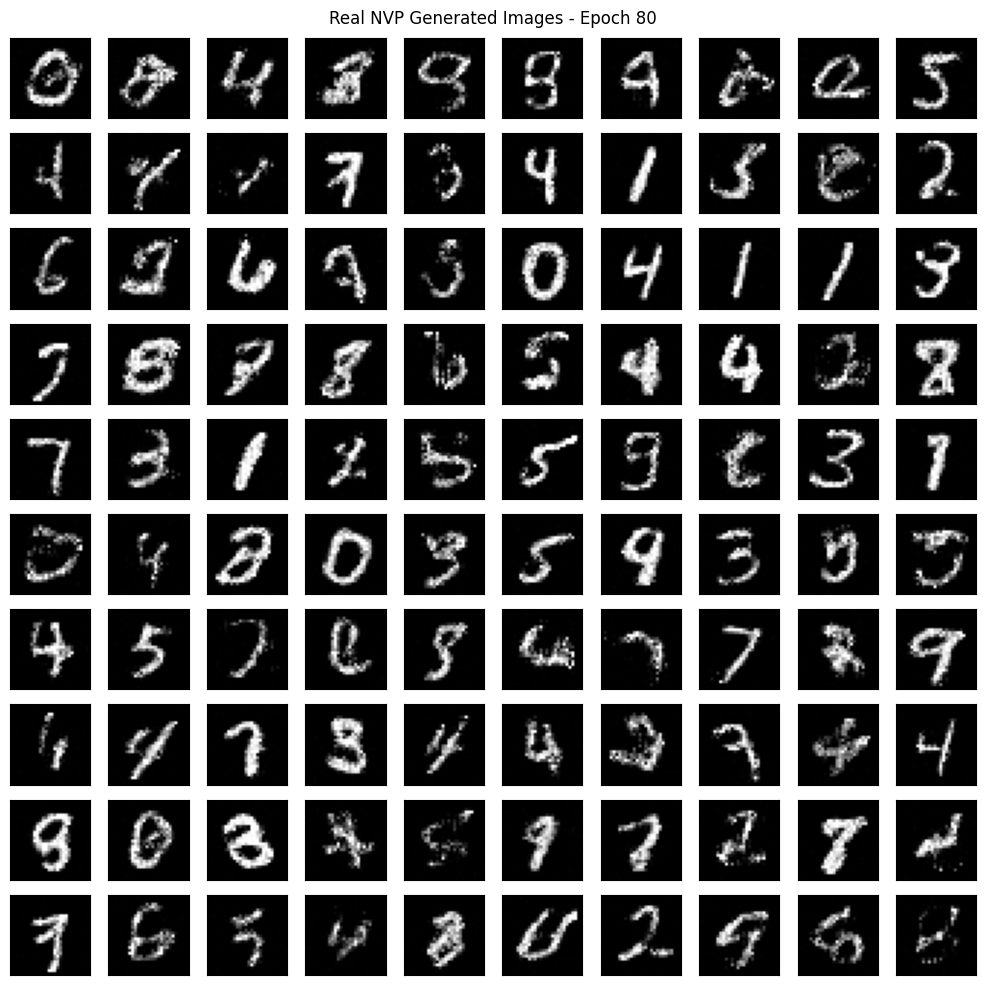

Training Real NVP:  80%|████████  | 80/100 [11:13<03:00,  9.02s/it]

Epoch 80 Summary:
  Avg loss per sample: -2851.28
  Avg base log prob per sample: -1243.69
  Avg Jacobian per sample: 4094.97
Epoch  81, Batch   0: Base_logp=-158274.7, Jacobian=526534.6, Loss=-368260.0
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  81%|████████  | 81/100 [11:21<02:45,  8.70s/it]

Epoch  82, Batch   0: Base_logp=-157858.1, Jacobian=528429.4, Loss=-370571.3
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  82%|████████▏ | 82/100 [11:30<02:34,  8.59s/it]

Epoch  83, Batch   0: Base_logp=-158131.9, Jacobian=525131.1, Loss=-366999.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  83%|████████▎ | 83/100 [11:38<02:24,  8.49s/it]

Epoch  84, Batch   0: Base_logp=-161227.8, Jacobian=524560.5, Loss=-363332.7
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  84%|████████▍ | 84/100 [11:46<02:13,  8.33s/it]

Epoch  85, Batch   0: Base_logp=-159647.7, Jacobian=525257.4, Loss=-365609.8
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  85%|████████▌ | 85/100 [11:54<02:04,  8.31s/it]

Epoch  86, Batch   0: Base_logp=-157860.3, Jacobian=525359.4, Loss=-367499.2
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  86%|████████▌ | 86/100 [12:02<01:56,  8.31s/it]

Epoch  87, Batch   0: Base_logp=-159860.2, Jacobian=522376.8, Loss=-362516.6
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


Training Real NVP:  87%|████████▋ | 87/100 [12:10<01:46,  8.17s/it]

Epoch  88, Batch   0: Base_logp=-158815.8, Jacobian=521912.7, Loss=-363096.9
  ⚠️  Extremely large Jacobian - possible volume explosion
  ⚠️  Very poor base distribution fit


In [ ]:
# Training setup
optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.01)
dataloader = DataLoader(trainX, batch_size=128, shuffle=True)

# Test forward pass before training
print("Testing Real NVP before training...")
with torch.no_grad():
    test_batch = next(iter(dataloader))[:5].to(device)
    test_z, test_jacobian = normalizing_flow(test_batch)
    test_base_logp = logistic_dist.log_pdf(test_z)
    test_likelihood = test_base_logp + test_jacobian
    test_loss = -test_likelihood.sum()

    print(f"Pre-training test:")
    print(f"  Input shape: {test_batch.shape}")
    print(f"  Transformed z shape: {test_z.shape}")
    print(f"  Jacobian shape: {test_jacobian.shape}")
    print(f"  Base log prob: {test_base_logp.sum().item():.2f}")
    print(f"  Log Jacobian: {test_jacobian.sum().item():.2f}")
    print(f"  Total likelihood: {test_likelihood.sum().item():.2f}")
    print(f"  Loss: {test_loss.item():.2f}")

# Verify invertibility before training
print("\nVerifying invertibility...")
with torch.no_grad():
    x_reconstructed = normalizing_flow.invert(test_z)
    reconstruction_error = torch.mean((test_batch - x_reconstructed) ** 2)
    print(f"Reconstruction MSE: {reconstruction_error.item():.2e}")

    if reconstruction_error.item() < 1e-4:
        print("✓ Invertibility verified!")
    else:
        print("⚠️ Invertibility issue detected!")

# Train the model
print("\nStarting Real NVP training...")
training_losses, base_log_probs, jacobian_terms = train_realnvp(
    normalizing_flow, optimizer, dataloader, logistic_dist,
    nb_epochs=100, device=device
)

print("\nReal NVP training completed!")

## Jacobian Analysis: Understanding Volume Changes

The Jacobian determinant tells us how much the transformation expands or contracts volumes. Let's analyze this in detail:

### Mathematical Background

**Volume Preservation vs Expansion:**
- `log|det(J)| = 0`: Volume preserving (NICE without scaling)
- `log|det(J)| > 0`: Volume expansion (data spreads out)
- `log|det(J)| < 0`: Volume contraction (data compresses)

**Real NVP Jacobian:**
$$\log|\det(J)| = \sum_{\text{layers}} \sum_{\text{dimensions}} s_i$$

Where $s_i$ are the scale parameters from each coupling layer.

## Training Functions and Loss Analysis

Now let's implement the training infrastructure and understand the unique aspects of flow-based training:"

## Key Takeaways: Real NVP vs Other Generative Models

### Advantages of Real NVP
1. **Exact Likelihood**: Unlike GANs/VAEs, provides exact likelihood computation
2. **Perfect Invertibility**: Can map between data and latent space exactly
3. **Stable Training**: More stable than GANs, deterministic unlike VAEs
4. **Tractable Sampling**: Direct sampling without approximation
5. **Theoretical Foundation**: Solid mathematical basis with change of variables

### Limitations of Real NVP
1. **Volume Expansion Issue**: May learn trivial volume-expanding transformations
2. **Architectural Constraints**: Coupling layers limit expressiveness
3. **Computational Cost**: Forward/inverse passes can be expensive
4. **Base Distribution Mismatch**: Transformed data may not fit chosen prior
5. **Unbounded Loss**: Can lead to optimization challenges

### Comparison Summary

| Aspect | Real NVP | VAE | GAN |
|--------|----------|-----|-----|
| **Likelihood** | Exact | Lower bound (ELBO) | None |
| **Training Stability** | Stable | Stable | Unstable |
| **Sample Quality** | Good | Blurry | Excellent |
| **Invertibility** | Perfect | Approximate | None |
| **Loss Bounds** | Unbounded | Bounded | Bounded |
| **Latent Inference** | Exact | Probabilistic | None |

### Volume Expansion Phenomenon
A key challenge in Real NVP training:
- **Problem**: Model may learn to expand volume massively instead of learning meaningful transformations
- **Detection**: Large positive Jacobian terms dominating likelihood
- **Solutions**: Better architectures (Glow, Flow++), different base distributions, regularization

### Best Practices for Real NVP
- **Initialization**: Zero initialization for coupling networks
- **Architecture**: Alternating masks, sufficient depth
- **Numerical Stability**: Bound scale parameters with tanh
- **Monitoring**: Track Jacobian and base likelihood separately
- **Base Distribution**: Consider alternatives to logistic if poor fit

### Modern Flow Improvements
- **Glow**: Invertible 1×1 convolutions, multi-scale architecture
- **Flow++**: Improved coupling layers, self-attention
- **Neural Spline Flows**: More expressive transformations
- **Continuous Normalizing Flows**: Neural ODEs for flows

---

**References:**
- Dinh, L., Sohl-Dickstein, J., & Bengio, S. (2016). Density estimation using Real NVP. arXiv preprint arXiv:1605.08803.
- Papamakarios, G., Nalisnick, E., Rezende, D. J., Mohamed, S., & Lakshminarayanan, B. (2019). Normalizing flows for probabilistic modeling and inference. arXiv preprint arXiv:1912.02762.